# Introduction

## Import and settings

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from scipy.special import expit

from IPython.display import display, Markdown
import matplotlib.pyplot as plt
import networkx as nx

from lingam.causal_based_simulator import CausalBasedSimulator
from lingam.utils import make_dot

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Creatig test data
The test data X is a data frame such that only x2 is a discrete variable and the other variables are continuous variables. x2 has either 0 or 1.  
The matrix G of the causal graph is needed to estimate the functional relationship in CausalBasedSimulator. Although the matrix elements are numeric to generate test data, CausalBasedSimulator ignores that volume and uses only zero or nonzero.

### Causal graph

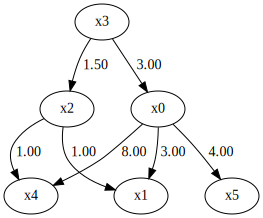

### Test data

,x0,x1,x2,x3,x4,x5
0,-0.725033,-0.853352,1,-0.298043,-5.518573,-3.361619
1,2.092471,5.580223,1,0.449011,17.970192,7.668833
2,3.251115,10.669606,1,0.965044,25.752890,11.510047
3,3.808976,13.150129,1,1.217832,30.951193,14.725043
4,3.023790,8.491654,1,1.096086,23.642615,11.167459


In [2]:
display(Markdown("### Causal graph"))

G = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 1.5, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0, 1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

causal_order = [3, 2, 0, 4, 1, 5]

display(make_dot(G))

display(Markdown("### Test data"))

N = 1000
n_features = len(G)
discrete_index = 2

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, N))
X = np.empty((n_features, N))
for i in causal_order:
    X[i] = G[i] @ X + e[i]
    if i == discrete_index:
        X[i] = (expit(X[i]) >= np.random.uniform(size=N)).astype(int)
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(n_features)])

X[f"x{discrete_index}"] = X[f"x{discrete_index}"].astype(int)

X.head()

## Estimating functional relationships between variables

Estimate functional relationships between variables by feeding test data to CausalBasedSimulator.

See the notebook *estimating_functional_felationships.ipynb* for more information.

In [3]:
sim = CausalBasedSimulator()
sim.train(X, G, is_discrete=[False, False, True, False, False, False])

Functional relationships between variables are stored in train_result_. The keys of the dictionary are the column names of X given to train().

In [4]:
sim.train_result_.keys()

dict_keys(['x0', 'x1', 'x2', 'x3', 'x4', 'x5'])

The values of this dictionary has information about the model for that variable.

In [5]:
sim.train_result_["x1"].keys()

dict_keys(['model', 'parent_names', 'predicted', 'residual'])

This dictionary contains the following four elements:
- model
  - An instance of the machine learning model for the variable.
- parent_names
  - List of parent names.
- predicted
  - Predicted values by model.
- residual
  - Estimated error data.

model contains trained sklearn.linear_model.LinearRegression by default when the variable is a continuous variable, and `sklearn.linear_model.LogisticRegression` when the variable is a discrete variable.

In [6]:
# x1 is a continuous variable
type(sim.train_result_["x1"]["model"])

sklearn.linear_model._base.LinearRegression

In [7]:
# x2 is a discrete variable
type(sim.train_result_["x2"]["model"])

sklearn.linear_model._logistic.LogisticRegression

`parent_names` is a list of names of parents.

In [8]:
sim.train_result_["x1"]["parent_names"]

['x0', 'x2']

`parent_names` of the exogenous variable is a empty list.

In [9]:
sim.train_result_["x3"]["parent_names"]

[]

`predicted` is a list of predicted values and `residual` is a list of estimated error values. When `residual` is added to `predicted`, it equals test data of x2.

In [10]:
predicted = sim.train_result_["x1"]["predicted"]
residual = sim.train_result_["x1"]["residual"]

np.isclose(predicted + residual, X["x1"]).all()

True

`residual` of a discrete variable is None.

In [11]:
sim.train_result_["x2"]["residual"] is None

True

## Generating simulated data

By running train() in CausalBasedSimulator, you can simulate the data when the model and errors are replaced.

For more information, see the notebook *generating_simulated_data.ipynb*.

In [12]:
# new x0 data
changing_exog = {
    "x0": np.random.laplace(0, 10, size=X.shape[0]),
}

# new x0 model
parent_names = sim.train_result_["x0"]["parent_names"]
new_model = LinearRegression()
new_model.fit(X[parent_names].values, X["x0"].values * 10)

changing_models = {
        # the target variable name
        "x0": {
            # names of explanatory variables
            "parent_names": parent_names,
            # new instance of the model
            "model": new_model,
        },
}

sim_df = sim.run(changing_exog=changing_exog, changing_models=changing_models)

Check the data generated counterfactually.

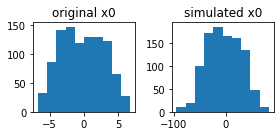

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].hist(X["x0"])
axes[0].set_title("original x0")
axes[1].hist(sim_df["x0"])
axes[1].set_title("simulated x0")
plt.tight_layout()
plt.show()

Another way to change the model is as follows:

In [14]:
# new x0 model
changing_models = {
        # the target variable name
        "x0": {
            # names of explanatory variables
            "parent_names": parent_names,
            # coefficient of new regression model
            "coef": [10],
        },
}

sim_df = sim.run(changing_models=changing_models)

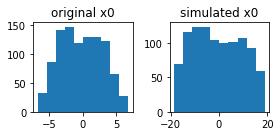

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
axes[0].hist(X["x0"])
axes[0].set_title("original x0")
axes[1].hist(sim_df["x0"])
axes[1].set_title("simulated x0")
plt.tight_layout()
plt.show()

## Use of causal graph and causal data with different assumptions

CausalBasedSimulator can handle the data with different assumptions. Argument *cd_algo_name* can be *DirectLiNGAM*, *ICALiNGAM*, *BottomUpParceLiNGAM*, or *VARLiNGAM*.

### DirectLiNGAM
The ICALiNGAM assumption is the same as the DirectLiNGAM assumption. *DirectLiNGAM* is the default value of *cd_algo_name*.

#### Test data

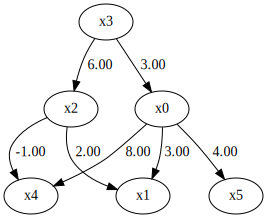

In [16]:
m = np.array([[0.0, 0.0, 0.0, 3.0, 0.0, 0.0],
              [3.0, 0.0, 2.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 6.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [8.0, 0.0,-1.0, 0.0, 0.0, 0.0],
              [4.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(len(m), 1000))

X = np.linalg.inv(np.eye(len(m)) - m) @ e
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(len(m))])

display(make_dot(m, labels=X.columns.tolist()))

#### Train and run

Let's simulate the case where x0 is an exogenous variable.

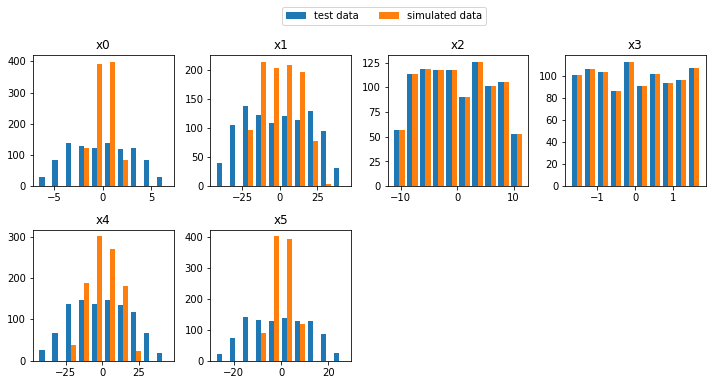

In [17]:
sim = CausalBasedSimulator()
sim.train(X, m, cd_algo_name="DirectLiNGAM")

# simulate
changing_models = {
    "x0": {
        # x0 has no parent.
        "parent_names": [],
    }
}
sim_df = sim.run(changing_models=changing_models)

def draw_hist(X, X2, n_cols=4, label=None):
    n_rows = X.shape[1] // n_cols + (X.shape[1] % n_cols > 0)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2.5, n_rows*2.5))
    for i, (ax, c) in enumerate(zip(axes.ravel(), X.columns)):
        ax.hist((X[c], X2[c]), label=label)
        ax.set_title(c)
        
    if label is not None:
        n_deletes = n_cols * n_rows - X.shape[1]
        for ax in axes.ravel()[:-(n_deletes + 1):-1]:
            ax.remove()
    
    plt.tight_layout()
    axes[0, 0].legend(bbox_to_anchor=((n_cols+1)/2, 1.3), ncol=2, loc="center")
    plt.show()
    
draw_hist(X, sim_df, label=("test data", "simulated data"))

### BottomUpParceLiNGAM

#### Test data

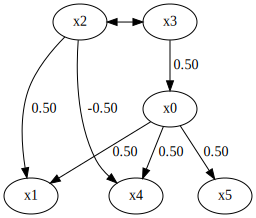

In [18]:
m = np.array([[0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0],
              [0.5, 0.0,-0.5, 0.0, 0.0, 0.0, 0.0],
              [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
              [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])

e = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(len(m), 1000))

X = np.linalg.inv(np.eye(len(m)) - m) @ e
X = pd.DataFrame(X.T, columns=[f"x{i}" for i in range(len(m))])

# make x6 unobserved
X = X.drop("x6", axis=1)
m = np.delete(np.delete(m, 6, axis=0), 6, axis=1)
m[2, 3] = np.nan
m[3, 2] = np.nan

display(make_dot(m, labels=X.columns.tolist()))

#### Train and run

Let's simulate the case where the effect from x3 to x0 is 10 times.

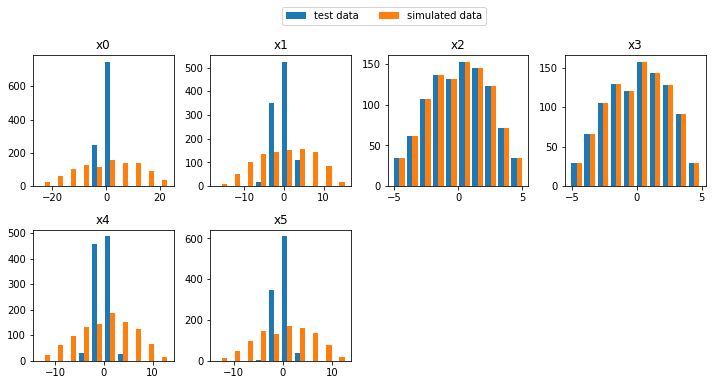

In [19]:
sim = CausalBasedSimulator()
sim.train(X, m, cd_algo_name="BottomUpParceLiNGAM")

# simulate
changing_models = {
    "x0": {
        # same as training results.
        "parent_names": sim.train_result_["x0"]["parent_names"],
        # All edge values to x0 are multiplied by 10.
        "coef": sim.train_result_["x0"]["model"].coef_ * 10,
    }
}

sim_df = sim.run(changing_models=changing_models)
draw_hist(X, sim_df, label=("test data", "simulated data"))

### VARLiNGAM

#### Test data

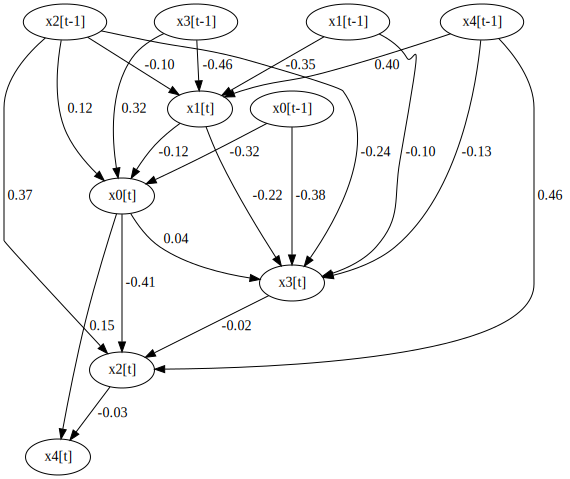

In [20]:
B = np.array([
    [
        [0,-0.12,0,0,0],
        [0,0,0,0,0],
        [-0.41,0.01,0,-0.02,0],
        [0.04,-0.22,0,0,0],
        [0.15,0,-0.03,0,0],
    ],
    [
        [-0.32,0,0.12,0.32,0],
        [0,-0.35,-0.1,-0.46,0.4],
        [0,0,0.37,0,0.46],
        [-0.38,-0.1,-0.24,0,-0.13],
        [0,0,0,0,0],
    ]
])

n_features = B.shape[1]
n_lags = len(B) - 1

sample_size = 1000
error = np.random.uniform(-np.sqrt(3), np.sqrt(3), size=(n_features, sample_size*2))

def _x_t(X, e, B):
    _, n_features, _ = B.shape
    term = np.linalg.pinv(np.eye(n_features) - B[0])
    term2 = np.hstack(B[1:]) @ np.hstack(X[:, ::-1][:, :len(B) - 1]).reshape(n_features, 1) + e
    return term @ term2

X = error[:, :n_lags]
for t in range(n_lags, len(error.T)):
    new_data = _x_t(X[:, :t], error[:, [t]], B)
    X = np.append(X, new_data, axis=1)
X = X[:, -sample_size:].T
X = pd.DataFrame(X, columns=[f"x{i}" for i in range(n_features)])

def to_dag(B):
    n_features = B.shape[1]
    concated = np.zeros((n_features * len(B), n_features * len(B)))
    concated[:n_features, :] = np.concatenate(B, axis=1)
    return concated
labels = [*[f"x{i}[t]" for i in range(n_features)], *[f"x{i}[t-1]" for i in range(n_features)]]
make_dot(to_dag(B), labels=labels)

#### Train and run

In [21]:
sim = CausalBasedSimulator()
sim.train(X, B, cd_algo_name="VARLiNGAM")

# simulate
changing_models = {
    "x2[t]": {
        # same as training results.
        "parent_names": sim.train_result_["x2[t]"]["parent_names"],
        # All edge values to x2[t] are multiplied by 10.
        "coef": sim.train_result_["x2[t]"]["model"].coef_ * 10,
    }
}

sim_df = sim.run(changing_models=changing_models)
sim_df

,x0[t],x1[t],x2[t],x3[t],x4[t],x0[t-1],x1[t-1],x2[t-1],x3[t-1],x4[t-1]
0,-0.626653,-1.618734,1.309133,0.387757,-0.144795,1.145837,-0.294643,-1.412436,1.495833,1.108421
1,-0.289264,-0.548810,-2.187802,-0.772525,-1.087198,-0.626653,-1.618734,-0.316811,0.387757,-0.072998
2,0.781397,0.250568,-16.348271,2.292111,1.949416,-0.289264,-0.548810,-1.523471,-0.772525,-1.116533
3,0.941369,-1.013878,-9.659237,-1.201516,0.626740,0.781397,0.250568,-2.940394,2.292111,1.357362
4,-1.747336,1.493297,7.576873,-0.673874,0.878771,0.941369,-1.013878,0.051357,-1.201516,0.197947
...,...,...,...,...,...,...,...,...,...,...
994,-0.009427,-1.100649,-8.621268,0.927859,-0.343643,0.965835,-0.957519,-1.256489,1.817561,-0.426456
995,0.765990,0.288367,-14.878097,1.508780,0.629663,-0.009427,-1.100649,-1.951126,0.927859,-0.638177
996,-0.261992,-0.023162,-7.595584,-0.231953,0.204981,0.765990,0.288367,-1.759764,1.508780,0.050395
997,-1.199114,1.838281,-3.859821,0.927962,0.532499,-0.261992,-0.023162,-1.835139,-0.231953,-0.049384


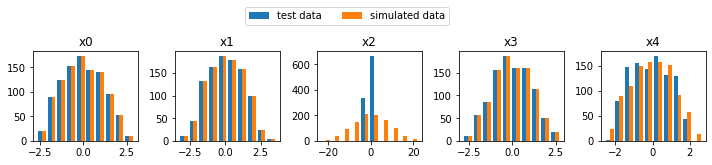

In [22]:
n_features = X.shape[1]
fig, axes = plt.subplots(1, n_features, figsize=(n_features*2, 2))

for i in range(n_features):
    axes[i].hist((X[f"x{i}"], sim_df[f"x{i}[t]"]), label=("test data", "simulated data"))
    axes[i].set_title(f"x{i}")
    
plt.tight_layout()
axes[0].legend(bbox_to_anchor=(3, 1.4), ncol=2, loc="center")
plt.show()